In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
X, Y = np.load('X.npy'), np.load('Y.npy')
print("X:", X.shape)
print("Y:", Y.shape)

X: (44992, 125, 45)
Y: (44992, 19)


In [3]:
np.random.seed(2222)
rand_index = np.random.permutation(X.shape[0])

test_size = int(0.1 * X.shape[0])

X_train = X[rand_index[:-test_size],:,:]
print('X_train shape:',X_train.shape)

Y_train = Y[rand_index[:-test_size],:]
print('Y_train shape:',Y_train.shape)

X_test = X[rand_index[-test_size:],:,:]
print('X_test shape:',X_test.shape)

Y_test = Y[rand_index[-test_size:],:]
print('Y_test shape:',Y_test.shape)

X_train shape: (40493, 125, 45)
Y_train shape: (40493, 19)
X_test shape: (4499, 125, 45)
Y_test shape: (4499, 19)


In [4]:
hm_epochs = 3
n_classes = 19
batch_size = 128
chunk_size = 45
n_chunks = 125
rnn_size = 128

X = tf.placeholder('float',[None, n_chunks, chunk_size])
Y = tf.placeholder('float')

In [5]:
def random_mini_batches(X, Y, mini_batch_size = batch_size, seed = None):
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    if not seed is None:
        np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m + 1 ,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m + 1 ,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [6]:
def compute_cost(Z3, Y):

#     cost = tf.reduce_mean(tf.square(Z3 - Y))
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [7]:
def recurrent_neural_network(x):
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size,n_classes])),
             'biases':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.transpose(x, [1,0,2])
    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, n_chunks, 0)

    lstm_cell = rnn_cell.BasicLSTMCell(rnn_size,state_is_tuple=True)
#     lstm_cell = rnn_cell.BasicLSTMCell(rnn_size,reuse=True)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    output = tf.matmul(outputs[-1],layer['weights']) + layer['biases']

    return output

In [8]:
def train_neural_network(X_train, Y_train, X_test, Y_test, minibatch_size = 128, learning_rate = 0.0001):
    prediction = recurrent_neural_network(X)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = Y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    costs = [] 
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(hm_epochs):
            
            epoch_cost = 0
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            hm_minibatches = len(minibatches)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
#                 minibatch_X = minibatch_X.reshape((batch_size,n_chunks,chunk_size))
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / hm_minibatches
                
#             for _ in range(int(X_train.shape[0]/batch_size)):
#                 epoch_x, epoch_y = mnist.train.next_batch(batch_size)
#                 epoch_x, epoch_y = X_train()             
#                 epoch_x = epoch_x.reshape((batch_size,n_chunks,chunk_size))
#                 _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
#                 epoch_loss += c

#             if epoch % 10 == 0:
            print('Epoch', epoch+1, 'completed out of',hm_epochs,', loss:',epoch_cost)
            if epoch > 1:
                costs.append(epoch_cost)
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Train Accuracy:',accuracy.eval({X: X_train, Y: Y_train}))
        print('Test Accuracy:',accuracy.eval({X: X_test, Y: Y_test}))

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

# train_neural_network(x)

Epoch 1 completed out of 10 , loss: 2.00591142339
Epoch 2 completed out of 10 , loss: 0.413340082163
Epoch 3 completed out of 10 , loss: 0.152757798178
Epoch 4 completed out of 10 , loss: 0.0788106832254
Epoch 5 completed out of 10 , loss: 0.0500660485703
Epoch 6 completed out of 10 , loss: 0.0343458868463
Epoch 7 completed out of 10 , loss: 0.0270984757777
Epoch 8 completed out of 10 , loss: 0.0201440748438
Epoch 9 completed out of 10 , loss: 0.0161758877586
Epoch 10 completed out of 10 , loss: 0.0136843986827
Train Accuracy: 0.993456
Test Accuracy: 0.985997


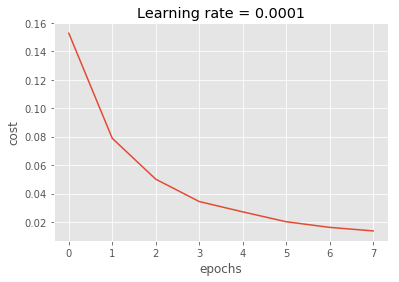

In [9]:
hm_epochs = 10
train_neural_network(X_train, Y_train, X_test, Y_test, minibatch_size = batch_size, learning_rate = 0.0001)

In [21]:
tmp = random_mini_batches(X_train, Y_train, mini_batch_size = batch_size, seed = None)

In [31]:
tmp[0][0].shape

(128, 125, 45)

In [38]:
a = tmp[0][0]
a = np.transpose(a, [1,0,2])
a = np.reshape(a, [-1, chunk_size])
a = np.split(a, n_chunks, 0)

In [34]:
a.shape

(125, 128, 45)

In [36]:
a.shape

(16000, 45)

In [37]:
125*128

16000

In [42]:
a[0].shape

(128, 45)